# Test Zeeman and Stark Hamiltonian

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-dark', 'notebook'])

from centrex_TlF import CoupledBasisState, UncoupledBasisState
from centrex_TlF.hamiltonian.utils import threej_f
from centrex_TlF.states.utils import matrix_to_states, find_state_idx_from_state
from centrex_TlF.constants import constants_B as cst_B
from TlF_hamiltonians.B_coupled_P import H_c1p, H_mhf_F, H_mhf_Tl, H_q, Hc1, Hrot, HSx, HSy, HSz, HZx, HZy, HZz
from TlF_hamiltonians.B_coupled_P.quantum_numbers import generate_QN
from TlF_hamiltonians.utils import calculate_matrix_reps, find_QN_indices

## Set up Hamiltonian

### Generate quantum numbers

In [2]:
QN = generate_QN(Jmin = 1, Jmax = 3)

### Calculate matrix rep for Hamiltonian

In [3]:
H_names = ["H_c1p", "H_mhf_F", "H_mhf_Tl", "H_q", "Hc1", "Hrot", "HSx", "HSy", "HSz", "HZx", "HZy", "HZz"]
H_list = [H_c1p, H_mhf_F, H_mhf_Tl, H_q, Hc1, Hrot, HSx, HSy, HSz, HZx, HZy, HZz]
matrix_reps = calculate_matrix_reps(H_list, QN)

H_dict = {H_name: M for H_name, M in zip(H_names, matrix_reps)}

In [4]:
H0_names = ["H_c1p", "H_mhf_F", "H_mhf_Tl", "H_q", "Hc1", "Hrot"]
H0 = sum([H_dict[name] for name in H0_names])

## Test Zeeman Hamiltonian
Testing the Zeeman Hamiltonian by making sure it reproduces the correct g-factors and checking that the Zeeman spectrum is the same for a magnetic field in any direction

### Hamiltonian as function of magnetic field

In [5]:
H_B = lambda B: H0 + B[0]*H_dict["HZx"] + B[1]*H_dict["HZy"] + B[2]*H_dict["HZz"]

Check that the Hamiltonian is Hermitian

In [6]:
B = np.array([1,1,1])
H_test = H_B(B)
print(f"Hamiltonian is Hermitian: {np.allclose(H_test, H_test.conj().T)}")

Hamiltonian is Hermitian: True


### Plot spectrum
Calculate eigenenergies of states at various magnetic field values and plot them

In [7]:
Bzs = np.linspace(-1000,1000,101)
energies = np.empty((len(QN), len(Bzs)))
for i, Bz in enumerate(Bzs):
    D, V = np.linalg.eigh(H_B(np.array([0,0,Bz])))
    energies[:,i] = D

Plot

Text(0, 0.5, 'Energy / MHz')

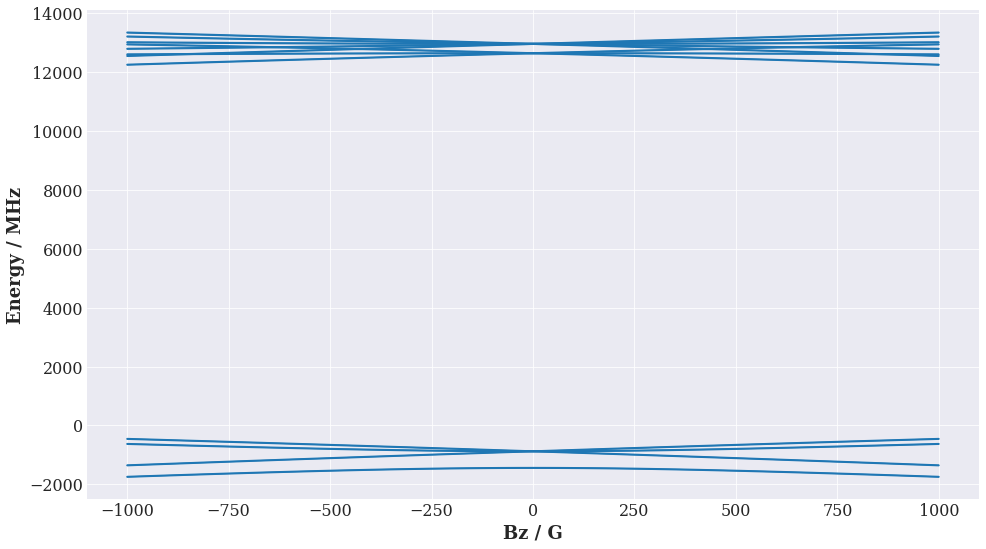

In [8]:
fig, ax = plt.subplots()

energies_plot = energies[find_QN_indices(QN, J = 1), :]

ax.plot(Bzs,energies_plot.T/(1e6), c = 'C0');
ax.set_xlabel('Bz / G')
ax.set_ylabel('Energy / MHz')

### g-factors
Calculate the g-factors for the states presented in [Meijer et al](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.101.042506) by setting B = 1G and dividing by the Bohr magneton

In [9]:
# Define the states whose g-factors need to be found
states = [
    1*CoupledBasisState(J=1, F1=1/2, F=0, mF=0, I1=1/2, I2=1/2, Omega=1),
    1*CoupledBasisState(J=1, F1=1/2, F=1, mF=1, I1=1/2, I2=1/2, Omega=1),
    1*CoupledBasisState(J=1, F1=3/2, F=1, mF=1, I1=1/2, I2=1/2, Omega=1),
    1*CoupledBasisState(J=1, F1=3/2, F=2, mF=1, I1=1/2, I2=1/2, Omega=1),
    1*CoupledBasisState(J=2, F1=5/2, F=2, mF=1, I1=1/2, I2=1/2, Omega=1),
    1*CoupledBasisState(J=2, F1=5/2, F=3, mF=1, I1=1/2, I2=1/2, Omega=1),
    1*CoupledBasisState(J=2, F1=3/2, F=1, mF=1, I1=1/2, I2=1/2, Omega=1),
    1*CoupledBasisState(J=2, F1=3/2, F=2, mF=1, I1=1/2, I2=1/2, Omega=1)
         ]

# Define Hamiltonian in zero magnetic field
H0G= H_B(np.array([0,0,0.000001]))

# Define Hamiltonian in magnetic field of 1G along z
H1G = H_B(np.array([0,0,1]))

# Calculate energies
E0G, V0G = np.linalg.eigh(H0G)
E1G, V1G = np.linalg.eigh(H1G)

# Find differences in energy and divide by Bohr magneton
mu_B = 1.4e6

for state in states:
    # Find state vector for state
    state_vec = state.state_vector(QN).reshape(-1,1)
    
    # Find which index corresponds to state
    i0 = np.argmax(np.abs(V0G.T@state_vec))
    i1 = np.argmax(np.abs(V1G.T@state_vec))
    
    # Find change in energy and divide by Bohr magneton to get gF
    gF = -(E1G[i1] - E0G[i0])/mu_B
    
    # Print result
    print(f"{state}\t:\tgF = {gF:.3f}")

1.00 x |J = 1, F₁ = 1/2, F = 0, mF = 0, I₁ = 1/2, I₂ = 1/2, Ω = 1>	:	gF = 0.000
1.00 x |J = 1, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, Ω = 1>	:	gF = 0.321
1.00 x |J = 1, F₁ = 3/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, Ω = 1>	:	gF = 0.253
1.00 x |J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, Ω = 1>	:	gF = 0.142
1.00 x |J = 2, F₁ = 5/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, Ω = 1>	:	gF = 0.111
1.00 x |J = 2, F₁ = 5/2, F = 3, mF = 1, I₁ = 1/2, I₂ = 1/2, Ω = 1>	:	gF = 0.077
1.00 x |J = 2, F₁ = 3/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, Ω = 1>	:	gF = 0.425
1.00 x |J = 2, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, Ω = 1>	:	gF = 0.254


### Check isotropicity
The direction of the magnetic field should not matter for the energies.

In [10]:
Bs = np.linspace(-1000,1000,101)
energies_x = np.empty((len(QN), len(Bs)))
energies_y = np.empty((len(QN), len(Bs)))
energies_z = np.empty((len(QN), len(Bs)))
for i, B in enumerate(Bs):
    energies_x[:,i], _ = np.linalg.eigh(H_B(np.array([B,0,0])))
    energies_y[:,i], _ = np.linalg.eigh(H_B(np.array([0,B,0])))
    energies_z[:,i], _ = np.linalg.eigh(H_B(np.array([0,0,B])))
    

In [11]:
np.allclose(energies_x, energies_y)

True

In [12]:
np.allclose(energies_x, energies_z)

True

## Test Stark Hamiltonian
Plotting the spectrum and checking isotropicity

### Hamiltonian as function of electric field

In [13]:
H_E = lambda E: H0 + E[0]*H_dict["HSx"] + E[1]*H_dict["HSy"] + E[2]*H_dict["HSz"]

Check that the Hamiltonian is Hermitian

In [14]:
E = np.array([1,1,1])
H_test = H_E(E)
print(f"Hamiltonian is Hermitian: {np.allclose(H_test, H_test.conj().T)}")

Hamiltonian is Hermitian: True


### Plot spectrum
Calculate eigenenergies of states at various electric field values and plot them

In [15]:
Ezs = np.linspace(-1000,1000,101)
energies = np.empty((len(QN), len(Bzs)))
for i, Ez in enumerate(Ezs):
    D, V = np.linalg.eigh(H_E(np.array([0,0,Ez])))
    energies[:,i] = D

Plot

Text(0, 0.5, 'Energy / MHz')

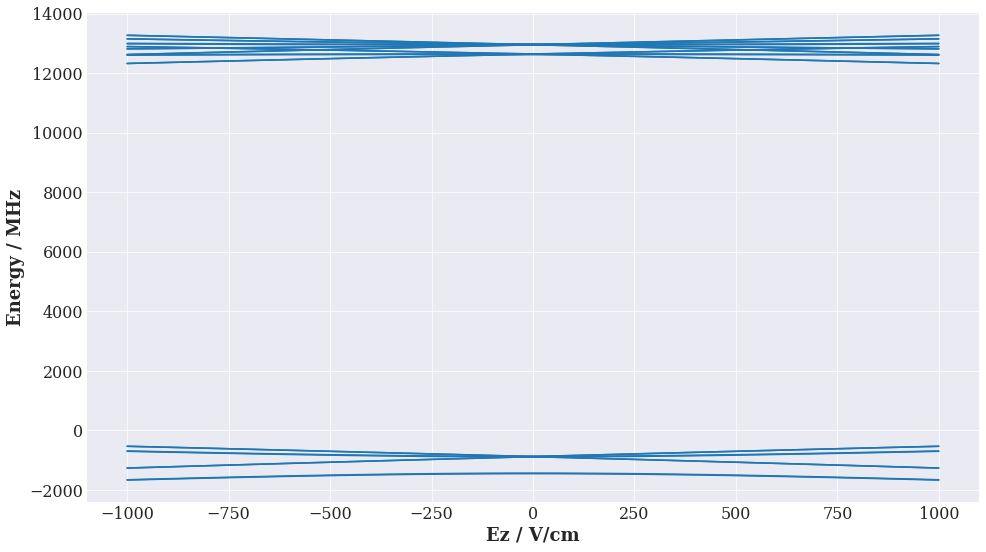

In [16]:
fig, ax = plt.subplots()

energies_plot = energies[find_QN_indices(QN, J = 1), :]

ax.plot(Bzs,energies_plot.T/(1e6), c = 'C0');
ax.set_xlabel('Ez / V/cm')
ax.set_ylabel('Energy / MHz')

### Check isotropicity
The direction of the electric field should not matter for the energies.

In [17]:
Es = np.linspace(-1000,1000,101)
energies_x = np.empty((len(QN), len(Es)))
energies_y = np.empty((len(QN), len(Es)))
energies_z = np.empty((len(QN), len(Es)))
for i, E in enumerate(Es):
    energies_x[:,i], _ = np.linalg.eigh(H_E(np.array([E,0,0])))
    energies_y[:,i], _ = np.linalg.eigh(H_E(np.array([0,E,0])))
    energies_z[:,i], _ = np.linalg.eigh(H_E(np.array([0,0,E])))
    

In [18]:
np.allclose(energies_x, energies_y)

True

In [19]:
np.allclose(energies_x, energies_z)

True